In [242]:
%load_ext autoreload
%autoreload 2

import json

import pandas as pd
import seaborn as sns

sns.set()

from importlib.resources import files

DATA_DIR = files("biobank_olink.data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from itertools import chain

results = [json.load(p.open()) for p in (DATA_DIR / "results").iterdir()]
results = pd.DataFrame(chain.from_iterable(results))
results.loc[results.model.isnull(), "model"] = "xgb"

results_lr = results.loc[(results.model == "lr") & (results.interactions.isnull())]
values = ["auc_score", "num_trials", "best_trial_no", "C"]
agg_values = {f"mean_{v}": (v, "mean") for v in values}
results_lr.groupby(["model", "panel", "target"]).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel           target                                    
lr    all             DBP           0.809236            541.4   
                      PP            0.736763            536.0   
                      SBP           0.819580            530.6   
      cardiometabolic DBP           0.767415            518.6   
                      PP            0.691272            536.0   
                      SBP           0.773917            519.2   
      inflammation    DBP           0.707595            537.0   
                      PP            0.655800            516.0   
                      SBP           0.717296            530.8   

                              mean_best_trial_no    mean_C  count  
model panel           target                                       
lr    all             DBP                  315.8  0.037637      5  
                      PP                   385.8  0.070706      5  
                      SBP                  380.6  0.048630      5  
      cardiometabolic DBP                  263.0  0.064746      5  
                      PP                   385.4  0.092845      5  
                      SBP                  282.0  0.080639      5  
      inflammation    DBP                  262.6  0.077726      5  
                      PP                   358.8  0.059871      5  
                      SBP                  306.8  0.089169      5

/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


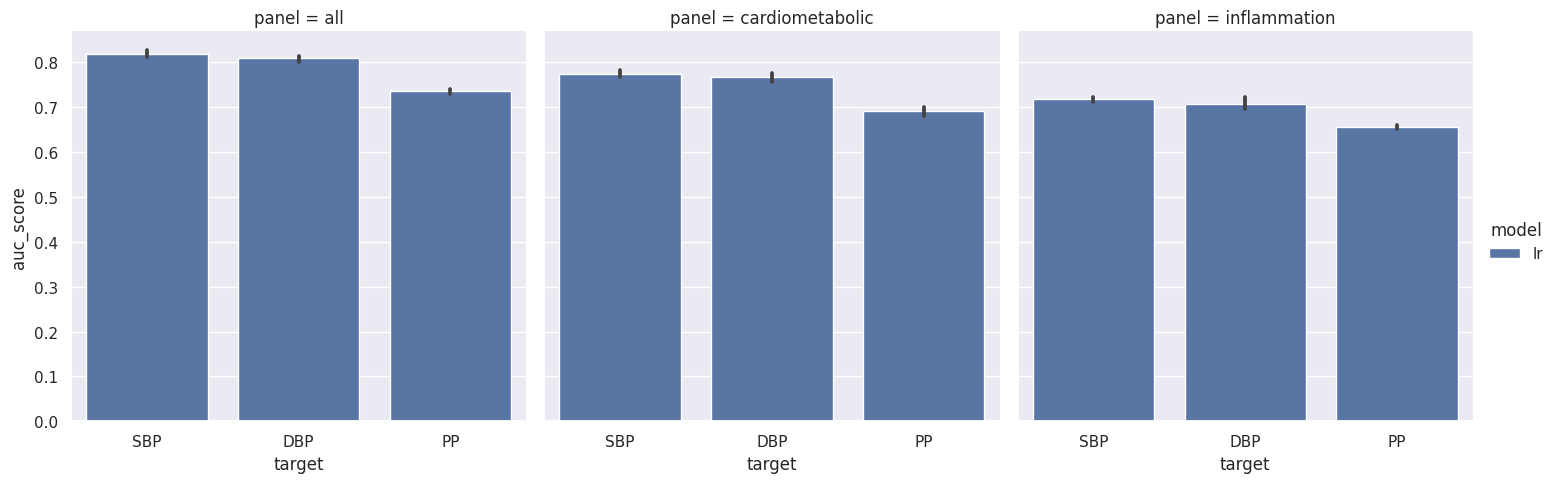

In [220]:
targets = ["SBP", "DBP", "PP"]
panels = ["all", "inflammation", "cardiometabolic"]
sns.catplot(data=results_lr, x="target", y="auc_score", order=targets, hue="model", col="panel",
            kind="bar")

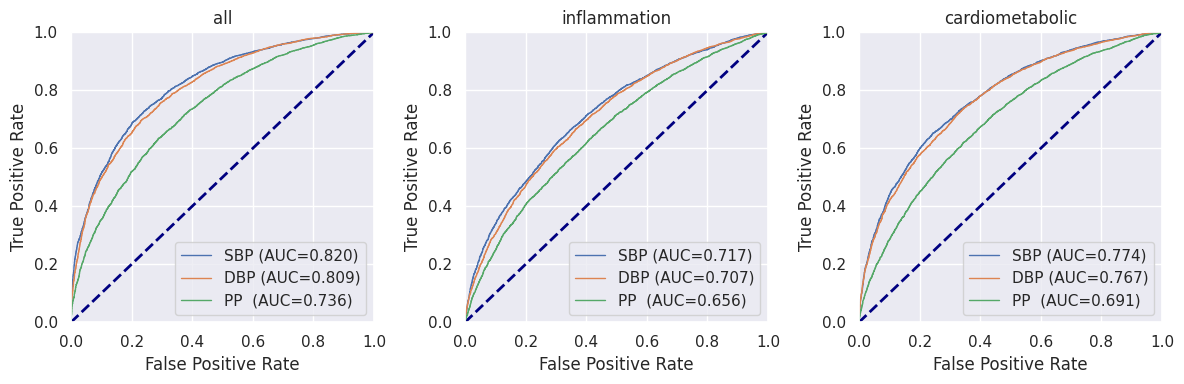

In [210]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for i, panel in enumerate(panels, 1):
    plt.subplot(1, 3, i)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(panel)

    text = ["AUC score:"]
    for target in targets:
        single_case = results_lr.loc[
            (results_lr.target == target) & (results_lr.panel == panel) & (results_lr.model == "lr")]
        y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
        y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=f"{target:<3} (AUC={auc_score:.3f})")

    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [211]:
feat_imps = results_lr.loc[
    (results_lr.target == "SBP") & (results_lr.model == "lr") & (results_lr.panel == "all")
    ].feat_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False).astype(int)

,0,1,2,3,4
REN,1,1,1,1,1
ACTA2,2,6,4,2,2
CHGB,3,4,2,3,3
VWC2,4,3,3,5,4
CRIP2,5,12,5,4,5
...,...,...,...,...,...
VSIR,1350,947,767,746,422
IL12A_IL12B,1350,410,305,275,849
SMPD1,1350,947,1206,1158,754
ITGA6,1350,947,427,1272,867


In [44]:
olink_assays = pd.read_csv(DATA_DIR / "olink-explore-3072-assay-list-2023-06-08.csv")
olink_assays["Explore 384 panel"] = olink_assays.loc[:, "Explore 384 panel"].apply(
    lambda x: x.split("_")[0])
assays_mapping = olink_assays.groupby("Explore 384 panel")["Gene name"].apply(set).to_dict()
list(assays_mapping.keys())


def olink_to_panels(olink):
    return [
        panel
        for panel, olinks in assays_mapping.items()
        if olink in olinks
    ]

In [38]:
from biobank_olink.dataset import load_datasets

ol_df, _ = load_datasets(cols_na_th=0.3, rows_na_th=0.3)
ol_df_corr = ol_df.corr()

corr_th = 0.9
mask = np.triu(np.ones(ol_df_corr.shape), k=1).astype(bool)
high_corr = ol_df_corr.where(mask)
correlated_cols = {column: dict(zip(high_corr.columns[high_corr[column] > corr_th].tolist(),
                                    high_corr[column][high_corr[column] > corr_th].tolist()))
                   for column in high_corr.columns}

dropping 2 columns in OLINK
dropping 99 rows in OLINK


In [257]:
def get_feat_imps(res, panel):
    feat_imps = (
        res.loc[(results.panel == panel)]
        .groupby("target").feat_importance
        .apply(lambda x: pd.DataFrame(x.values.tolist()).mean().sort_values(ascending=False))
        .unstack("target")
    )
    present_targets = [col for col in targets if col in feat_imps.columns]
    feat_imps = feat_imps[present_targets]
    feat_ranks = feat_imps.rank(ascending=False)
    feat_ranks.columns = [f"{col}_rank" for col in feat_ranks.columns]
    feat_imps = pd.concat([feat_imps, feat_ranks], axis=1)
    feat_imps = feat_imps[[f"{col}{suffix}" for col in present_targets for suffix in ["", "_rank"]]]
    return feat_imps

feat_imps = get_feat_imps(results_lr, "all")
feat_imps["panel"] = feat_imps.index.map(olink_to_panels)
feat_imps[f"correlates_with (corr>{corr_th})"] = feat_imps.index.map(correlated_cols)
feat_imps.sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank,panel,correlates_with (corr>0.9)
REN,2.849398e-02,1.0,3.654526e-02,1.0,0.014061,1.0,[Cardiometabolic],{}
CHGB,9.296244e-03,2.0,8.024357e-03,5.0,0.009666,2.0,[Neurology],{}
ACTA2,8.708967e-03,3.0,8.833069e-03,4.0,0.006235,4.0,[Cardiometabolic],{}
VWC2,8.278887e-03,4.0,7.131446e-03,11.0,0.004779,15.0,[Neurology],{}
CRIP2,7.762975e-03,5.0,1.048396e-02,3.0,0.006121,6.0,[Neurology],{}
...,...,...,...,...,...,...,...,...
CPB1,5.083330e-08,1350.0,8.625511e-07,1042.0,0.000023,1261.0,[Cardiometabolic],{'CPA1': 0.9012009137240349}
CASP2,4.513940e-08,1351.0,2.688793e-07,1167.0,0.000066,1161.0,[Inflammation],{}
APLP1,3.996962e-08,1352.0,7.488923e-04,375.0,0.000002,1329.0,[Cardiometabolic],{}
ARHGEF12,3.033304e-08,1353.0,7.737196e-07,1049.0,0.000007,1299.0,[Inflammation],{}


<Axes: >

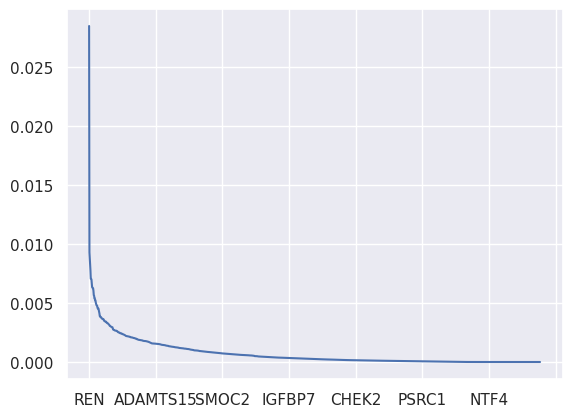

In [258]:
feat_imps.SBP.sort_values(ascending=False).plot()

In [238]:
# export feature importances
feat_importances_dir = DATA_DIR / "feat_importances"
feat_importances_dir.mkdir(exist_ok=True)
exp_cases = results_lr[["study_name", "target", "panel"]].drop_duplicates()
for _, (study_name, target, panel) in exp_cases.iterrows():
    single_case = results.loc[
        (results.study_name == study_name) &
        (results.target == target) &
        (results.panel == panel) &
        (results.model == "lr")
    ]

    feat_imps = single_case.feat_importance
    feat_imps = pd.DataFrame(feat_imps.tolist()).mean().reset_index()
    feat_imps.columns = ["feature", "importance"]
    feat_imps.to_csv(feat_importances_dir / f"{study_name}.csv", index=False)

## Interactions

In [244]:
res_inter = results.loc[results.interactions.notna()]
res_inter.groupby(["model", "panel", "target"]).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel           target                                    
lr    all             DBP           0.795019            214.8   
                      PP            0.714323            772.0   
                      SBP           0.803500            730.6   
      cardiometabolic DBP           0.753617            292.0   
                      PP            0.666726            624.8   
                      SBP           0.758168            650.0   
      inflammation    DBP           0.686795            731.0   
                      PP            0.627629           1043.6   
                      SBP           0.689192            537.8   

                              mean_best_trial_no    mean_C  count  
model panel           target                                       
lr    all             DBP                  170.0  0.018408      5  
                      PP                   197.8  0.016414      5  
                      SBP                  372.8  0.019428      5  
      cardiometabolic DBP                  107.4  0.016962      5  
                      PP                   483.2  0.015089      5  
                      SBP                  228.4  0.017358      5  
      inflammation    DBP                  438.4  0.014695      5  
                      PP                   577.8  0.017004      5  
                      SBP                  190.0  0.015724      5

In [261]:
get_feat_imps(res_inter, "all").sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.046747,1.0,0.048907,1.0,0.031770,1.0
CHGB,0.014414,2.0,0.010343,5.0,0.021168,2.0
ACTA2,0.013104,3.0,0.009918,7.0,0.012468,7.0
EFNA1,0.010540,4.0,0.004884,31.0,0.017795,3.0
VWC2,0.010162,5.0,0.007309,17.0,0.006705,20.0
...,...,...,...,...,...,...
VWC2*TGFBR3,NaN,NaN,NaN,NaN,0.000226,692.0
VWC2*TMPRSS15,NaN,NaN,0.000261,648.0,NaN,NaN
VWC2*TNFRSF13B,NaN,NaN,NaN,NaN,0.000039,1148.0
VWC2*TNFRSF19,NaN,NaN,0.000000,3983.0,NaN,NaN
